# Titanic
... or how to build a linear model and neural net from scratch

See: https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch


## Getting set up

In [ ]:
import os
from pathlib import Path

In [ ]:
!pip install kaggle  # make sure kaggle api is here so we can use it to dowload the dataset

In [ ]:
! pip install sympy

In [ ]:
#|eval: false
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
#|eval: false
isRunningOnKaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if isRunningOnKaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#|eval: false
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Analyzing and cleaning the data

In [ ]:
#|eval: false
# for local run: unzipt the data first into 'titanic' directory
df = pd.read_csv('./titanic/train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


The idea here is that we multiply each column by some coefficient and add those all up to get to a result that will predict if a person survived or not.

In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

This learns us that there's some columns like "Age" and "Cabin" and "Embarked" that have no values - which is problematic as we can't multiply "nothing" by a coefficient.  We'll replace these with "the mode" of the respective column, which is the most common value.

In [ ]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [ ]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Here we go - no more missing values.

In [ ]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

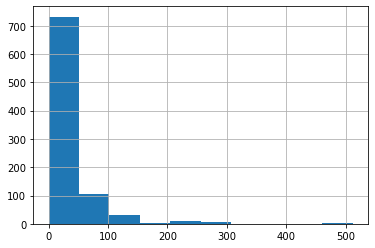

In [ ]:
df['Fare'].hist()

As we can see, Fare is not equally distributed compared to the other variables, so lets take the log of that:

In [ ]:
df['LogFare'] = np.log(df['Fare']+1)

<AxesSubplot:>

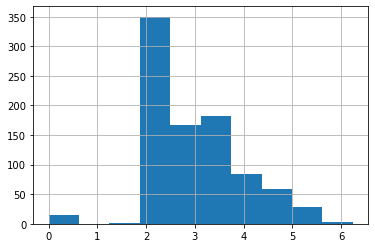

In [ ]:
df['LogFare'].hist()

In [ ]:
df.Pclass.unique()

array([3, 1, 2])

In [ ]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Now, we can't mulitply non-numbers by coefficients, so let's replace categories like Male and Female with numbers instead.

In [ ]:
df = pd.get_dummies(df, columns=['Sex','Pclass','Embarked'])
df

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,B96 B98,2.639057,0,1,0,1,0,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,3.433987,1,0,1,0,0,0,0,1
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,B96 B98,3.196630,1,0,0,0,1,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,3.433987,0,1,1,0,0,1,0,0


Note how this `get_dummies` function removed the original columns and included the new ones.

In [ ]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


## Prepare dependent and independent variables

Our dependent variable is easy: we're trying to predict if someone survived Titanic:

In [ ]:
from torch import tensor
t_dep = tensor(df.Survived)
t_dep

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 

Our independent variables are all the columns we want to use to predict the outcome with:

In [ ]:
indep_cols = ['Age','SibSp','Parch', 'LogFare'] + added_cols
indep_cols

['Age',
 'SibSp',
 'Parch',
 'LogFare',
 'Sex_male',
 'Sex_female',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [ ]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [ ]:
t_indep.shape

torch.Size([891, 12])

This tells us that we have data for 891 people (rows) with each having 12 indep variables associated (cols).  These number represent row by row our x-values while we'll initialize our weights at random.

## Setting up a Linear Model

### Get to predictions

At first we'll do a manual single step of
- calculating predictions
- calculating the loss for these

In [ ]:
# make sure our random numbers are "predictable" when we re-run the notebook:
torch.manual_seed(42)

In [ ]:
n_coeff = t_indep.shape[1]
n_coeff

12

We'll initialize 12 coefficients, one for each column upon which we'll base our predictions.

In [ ]:
coeffs = torch.rand(n_coeff)
coeffs

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408, 0.1332, 0.9346, 0.5936])

This gets us coeffs which are between 0 and 1. Let's make sure these are between -0.5 and 0.5 instead:

In [ ]:
coeffs = torch.rand(n_coeff) - 0.5
coeffs

tensor([ 0.3694,  0.0677,  0.2411, -0.0706,  0.3854,  0.0739, -0.2334,  0.1274, -0.2304, -0.0586, -0.2031,  0.3317])

We will multiply every row with these coefficients to get to our prediction, so we'll do this for every person:

In [ ]:
t_indep * coeffs

tensor([[ 8.1269,  0.0677,  0.0000, -0.1490,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [14.0374,  0.0677,  0.0000, -0.3022,  0.0000,  0.0739, -0.2334,  0.0000, -0.0000, -0.0586, -0.0000,  0.0000],
        [ 9.6045,  0.0000,  0.0000, -0.1545,  0.0000,  0.0739, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [12.9292,  0.0677,  0.0000, -0.2817,  0.0000,  0.0739, -0.2334,  0.0000, -0.0000, -0.0000, -0.0000,  0.3317],
        [12.9292,  0.0000,  0.0000, -0.1555,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [ 8.8657,  0.0000,  0.0000, -0.1586,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.2031,  0.0000],
        [19.9478,  0.0000,  0.0000, -0.2801,  0.3854,  0.0000, -0.2334,  0.0000, -0.0000, -0.0000, -0.0000,  0.3317],
        ...,
        [ 9.2351,  0.0000,  0.0000, -0.1472,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [14.4068,  0.0000,  1.2055, -0.2404

The first col jumps out: it has way higher values than all the rest.  We'll want to normalize this and make sure all cols are between 0 and 1 by dividing by their max value:

In [ ]:
vals, indices = t_indep.max(dim=0)
(vals, indices)

(tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]),
 tensor([630, 159, 678, 258,   0,   1,   1,   9,   0,   1,   5,   0]))

In [ ]:
t_indep = t_indep / vals # Note: this uses "broadcasting"
t_indep

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [ ]:
t_indep * coeffs  # this now provides the values which are to be added row by row

tensor([[ 0.1016,  0.0085,  0.0000, -0.0239,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [ 0.1755,  0.0085,  0.0000, -0.0484,  0.0000,  0.0739, -0.2334,  0.0000, -0.0000, -0.0586, -0.0000,  0.0000],
        [ 0.1201,  0.0000,  0.0000, -0.0248,  0.0000,  0.0739, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [ 0.1616,  0.0085,  0.0000, -0.0451,  0.0000,  0.0739, -0.2334,  0.0000, -0.0000, -0.0000, -0.0000,  0.3317],
        [ 0.1616,  0.0000,  0.0000, -0.0249,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [ 0.1108,  0.0000,  0.0000, -0.0254,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.2031,  0.0000],
        [ 0.2493,  0.0000,  0.0000, -0.0449,  0.3854,  0.0000, -0.2334,  0.0000, -0.0000, -0.0000, -0.0000,  0.3317],
        ...,
        [ 0.1154,  0.0000,  0.0000, -0.0236,  0.3854,  0.0000, -0.0000,  0.0000, -0.2304, -0.0000, -0.0000,  0.3317],
        [ 0.1801,  0.0000,  0.2009, -0.0385

In [ ]:
preds = (t_indep * coeffs).sum(dim=1)
(preds.shape, preds[:5])

(torch.Size([891]), tensor([ 0.5729, -0.0826,  0.2705,  0.2971,  0.6235]))

This gives us 891 predictions (out of which only 5 shown above), one for each person (row in our original t_indep matrix).

### Calculate loss

In [ ]:
prediction_errors = preds-t_dep  # this gives the rror for each person, compared to the truth value from t_dep
prediction_errors[:5]            # show 5 examples

tensor([ 0.5729, -1.0826, -0.7295, -0.7029,  0.6235])

In [ ]:
abs_pred_errors = torch.abs(prediction_errors)
abs_pred_errors[:5]

tensor([0.5729, 1.0826, 0.7295, 0.7029, 0.6235])

In [ ]:
mean_error = abs_pred_errors.mean()
mean_error

tensor(0.5908)

This is our loss.  Note that so far we've not done any optimization steps.  To do this, we'll create some helper functions first.

In [ ]:
def calc_preds(coeffs, indeps): return (indeps * coeffs).sum(dim=1)
def calc_loss(coeffs, indeps, deps): return (torch.abs(calc_preds(coeffs, indeps)-deps)).mean()

In [ ]:
calc_loss(coeffs, t_indep, t_dep) # see if our function gets to the same result as we've seen manually

tensor(0.5908)

### Gradient Descent

In [ ]:
coeffs.requires_grad_()

tensor([ 0.3694,  0.0677,  0.2411, -0.0706,  0.3854,  0.0739, -0.2334,  0.1274, -0.2304, -0.0586, -0.2031,  0.3317], requires_grad=True)

Now are coefficients are marked so the gradients are being tracked throughout the calculations we do with those.  Let's calculate our loss with the coefficients:

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5908, grad_fn=<MeanBackward0>)

We can now ask to calculate our gradients with respect to each weight / coefficient:

In [ ]:
loss.backward()
coeffs.grad

tensor([ 0.0826,  0.0174, -0.0007,  0.0453,  0.4052, -0.2088, -0.0651,  0.0157,  0.2458, -0.0382, -0.0034,  0.2379])

In [ ]:
coeffs

tensor([ 0.3694,  0.0677,  0.2411, -0.0706,  0.3854,  0.0739, -0.2334,  0.1274, -0.2304, -0.0586, -0.2031,  0.3317], requires_grad=True)

Let's take our first weight:  if we increase our first coefficient with 1, then our resulting loss will increase with that weight.  This only goes for very small tiny amounts those, so let's not try this with 1 but rather with for example 0.01

In [ ]:
coeffs_increased_first = coeffs + tensor([0.01,0,0,0,0,0,0,0,0,0,0,0])
coeffs_increased_first # increased the first of our weights with 1

tensor([ 0.3794,  0.0677,  0.2411, -0.0706,  0.3854,  0.0739, -0.2334,  0.1274, -0.2304, -0.0586, -0.2031,  0.3317],
       grad_fn=<AddBackward0>)

In [ ]:
coeffs.grad.zero_()  # don't forget to reset gradients as normally those get added every time they are calculated
loss_new = calc_loss(coeffs_increased_first, t_indep, t_dep)
loss_new

tensor(0.5916, grad_fn=<MeanBackward0>)

The difference of this new loss with our previous loss is:

In [ ]:
(loss_new-loss)*100

tensor(0.0826, grad_fn=<MulBackward0>)

See how our loss is now slightly higher, with approximately or exactly the same amount as our gradient told us.

Let's take a single Gradient Descent step:

In [ ]:
coeffs.grad.zero_()
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    lower_loss = calc_loss(coeffs, t_indep, t_dep)
    print(f'first our loss was {loss} and after our gradient descent step it was: {lower_loss}')

first our loss was 0.590818464756012 and after our gradient descent step it was: 0.5592127442359924


### Training the linear model

For training our model we also need a validation set.  To create such set we can use `RandomSplitter` from FastAI:

In [ ]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)
print(f'Our training set has {len(trn_split)} items while our validation set has {len(val_split)} items')

Our training set has 713 items while our validation set has 178 items


The contents of those lists coming from `RandomSplitter` are merely indexes.  We can apply them to our data:

In [ ]:
trn_indep, trn_dep = t_indep[trn_split], t_dep[trn_split]
val_indep, val_dep = t_indep[val_split], t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

Let's create some functions:

In [ ]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")
    
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [ ]:
def train_model(epochs=50, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [ ]:
coeffs = train_model(50, 0.1)

0.536; 0.518; 0.503; 0.489; 0.477; 0.465; 0.454; 0.443; 0.431; 0.420; 0.410; 0.399; 0.388; 0.378; 0.368; 0.358; 0.350; 0.343; 0.337; 0.330; 0.325; 0.319; 0.315; 0.310; 0.309; 0.302; 0.301; 0.296; 0.295; 0.290; 0.291; 0.285; 0.284; 0.280; 0.280; 0.275; 0.276; 0.270; 0.271; 0.266; 0.269; 0.264; 0.267; 0.263; 0.264; 0.261; 0.262; 0.259; 0.258; 0.257; 

See how the loss is going down!  Let's look at the coefficients for each feature column:

In [ ]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2391),
 'SibSp': tensor(0.0568),
 'Parch': tensor(0.2175),
 'LogFare': tensor(0.0012),
 'Sex_male': tensor(-0.4694),
 'Sex_female': tensor(0.3018),
 'Pclass_1': tensor(0.6391),
 'Pclass_2': tensor(0.4451),
 'Pclass_3': tensor(0.4072),
 'Embarked_C': tensor(0.1547),
 'Embarked_Q': tensor(0.2134),
 'Embarked_S': tensor(0.1760)}

Let's see how we do on our validation set, with data that has never been seen by our model:

In [ ]:
preds = calc_preds(coeffs, val_indep)
print(f'we have now {len(preds)} predictions for our validation set.  First 5 are:')
preds[:5]

we have now 178 predictions for our validation set.  First 5 are:


tensor([0.8891, 0.0799, 0.0212, 0.0987, 0.0775])

In [ ]:
results = val_dep.bool() == (preds>0.5)
results

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True, False, False,  True,  True,  True,  True, False, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True, False,  True,  True, False, False,  True,
         True,  True, False,  True,  True,  True,  True, False,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True

In [ ]:
print(f'our average accuracy is: {results.float().mean()}')
preds

our average accuracy is: 0.7921348214149475


tensor([     0.8891,      0.0799,      0.0212,      0.0987,      0.0775,      0.0578,      0.8885,      0.8398,      0.2196,      0.8360,
             0.0186,      0.0646,      0.1457,      0.8511,      0.0126,      0.2118,      0.1520,      0.8851,      0.0358,      0.7928,
             0.0425,      0.1789,      1.0233,      0.8599,      0.0544,      0.0872,      0.9259,      0.1610,      0.0634,      0.8511,
             0.9421,      0.9460,      0.0574,      0.0231,      0.8712,      0.9806,      0.2059,      1.0247,      0.0425,      0.8179,
             0.0954,      0.0425,      0.1157,      1.0008,      0.0544,      0.9445,      0.0369,      0.0808,      0.0799,      0.8197,
             0.2666,      0.1957,      0.1885,      0.0395,      0.0745,      0.0565,      0.0799,      0.0139,      0.0515,      0.0292,
             0.2353,      0.0705,      0.1072,      0.0515,      0.7992,      0.3200,      0.0805,     -0.0021,      0.0755,      0.7890,
             0.0365,      0.8650, 

In [ ]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
print(f'our accuracy is: {acc(coeffs)}')

our accuracy is: 0.7921348214149475


### Sigmoid normalization

Some of our predictions are below zero and some are above 1 - let's normalize those using a sigmoid function:

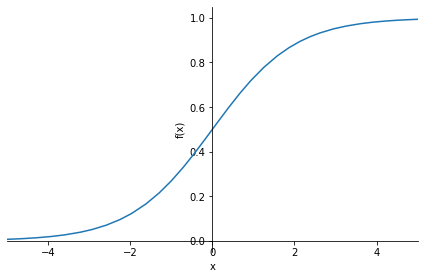

In [ ]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1)) # this redefines the prev function

In [ ]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 

In [ ]:
print(f'our accuracy is: {acc(coeffs)}')  # is improved normally

our accuracy is: 0.8258426785469055


## Submit to Kaggle



In [ ]:
test_df = pd.read_csv('./titanic/test.csv')
test_df['Fare'] = test_df.Fare.fillna(0)

In [ ]:
test_df.fillna(modes, inplace=True)
test_df['LogFare'] = np.log(test_df['Fare']+1)
test_df = pd.get_dummies(test_df, columns=["Sex","Pclass","Embarked"])

test_indep = tensor(test_df[indep_cols].values, dtype=torch.float)
test_indep = test_indep / vals
vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [ ]:
test_df['Survived'] = (calc_preds(test_indep, coeffs)>0.5).int()

In [ ]:
sub_df = test_df[['PassengerId','Survived']]

In [ ]:
sub_df.to_csv('./titanic/sub.csv', index=False)

In [ ]:
# command line to submit to Kaggle:
# kaggle competitions submit -c titanic -f nbs/titanic/sub.csv -m "first submission"

## Using a Matrix product

When we multiplied our weights/coefficients with our inputs (independent vars), that looked like this:

In [ ]:
print(f'shape for our indep variables: {val_indep.shape} and for our coeffs: {coeffs.shape}')
output = (val_indep*coeffs).sum(axis=1)  # [x1, x2, x3, ..., x12] * [c1, c2, c3, ..., c12]
print(f'shape of the output: {output.shape}')
output

shape for our indep variables: torch.Size([178, 12]) and for our coeffs: torch.Size([12])
shape of the output: torch.Size([178])


tensor([ 13.6089, -14.7533, -15.4929, -13.1274, -13.3325, -13.6610,   4.0167,   5.8253, -23.0645,   3.4834, -22.6130, -15.7467, -22.3585,
          4.4615, -22.6582, -12.4425, -12.8174,   5.8064, -13.5660,  -3.3766, -22.4632, -12.6487,  13.6359,   5.1308, -22.3926, -14.8863,
         -3.0881, -12.7612, -22.3283,   4.4609,   5.8044,  -4.1316, -22.3695, -22.5843,  13.4964,  -3.7069, -12.4694,  14.1804, -22.4624,
         -3.4474, -13.2288, -22.4624, -13.7275,  14.0347, -22.3875,  -4.0215, -22.4182, -22.6391, -14.7575,  -3.2149,  -5.0196, -23.2145,
        -23.0521, -22.4864, -13.3600, -13.4725, -14.7532, -22.8404, -22.4062, -22.5187,  -5.1856, -22.5161, -13.0934, -22.4068,   5.3747,
        -12.0506, -13.3138, -22.6985, -15.3090,   5.5082, -22.5007,   3.5429, -13.4537, -22.4559, -12.0498, -22.3138, -22.4624, -12.4381,
        -13.2201, -13.7391, -13.2998,  13.7273, -22.4445, -22.4665,   5.4042,  -6.6977,  -5.0811,   7.0301,  12.6450, -13.2951, -22.6109,
        -22.4624,  14.0867, -15.60

How the operator * works on tensors:

In [ ]:
t1 = torch.tensor([1,2,3])
t2 = torch.tensor([2])
t3 = t1 * t1 # elementwise multiplication: tensor([1, 4, 9])
t4 = t1 * t2  # broadcasting: tensor([2, 4, 6])
t5 = torch.tensor([2,3])
# this gives an error: t6 = t1 * t5 => The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0
t7 = torch.tensor([1,2,3]) * torch.tensor([2,3,4]) # tensor([ 2,  6, 12]) => element wise

We can however be more efficient by using a matrix dot product to calculate our indep * coeffs:

In [ ]:
# For the behavior of matrix multiplication operator @, see:
# https://pytorch.org/docs/stable/generated/torch.matmul.html
# the behavior depends on the dimensionality of the params:
torch.tensor([1,2,3])@torch.tensor([2,4,6]) # is: 2 + 8 + 18 = 28
a = torch.tensor( [2, 3, 4])
b = torch.tensor([[1, 2, 3],
                  [2, 3, 1],
                  [3, 2, 1]])
print(f'a is: {a}')
print(f'b is {b}')
print(f'a is a 1x3 matrix and b a 3x3 matrix, so result should be a 1x3 matrix')
a@b # [2+6+12=20, 4+9+8=21, 6+3+4=13]

a is: tensor([2, 3, 4])
b is tensor([[1, 2, 3],
        [2, 3, 1],
        [3, 2, 1]])
a is a 1x3 matrix and b a 3x3 matrix, so result should be a 1x3 matrix


tensor([20, 21, 13])

In [ ]:
output = val_indep @ coeffs  # this simple operation replaces: (val_indep*coeffs).sum(axis=1)
print(f'shape of the output: {output.shape}')
output

shape of the output: torch.Size([178])


tensor([ 13.6089, -14.7533, -15.4929, -13.1274, -13.3325, -13.6610,   4.0167,   5.8253, -23.0645,   3.4834, -22.6130, -15.7467, -22.3585,
          4.4615, -22.6582, -12.4425, -12.8174,   5.8064, -13.5660,  -3.3766, -22.4632, -12.6487,  13.6359,   5.1308, -22.3926, -14.8863,
         -3.0881, -12.7612, -22.3283,   4.4609,   5.8044,  -4.1316, -22.3695, -22.5843,  13.4964,  -3.7069, -12.4694,  14.1804, -22.4624,
         -3.4474, -13.2288, -22.4624, -13.7275,  14.0347, -22.3875,  -4.0215, -22.4182, -22.6391, -14.7575,  -3.2149,  -5.0196, -23.2145,
        -23.0521, -22.4864, -13.3600, -13.4725, -14.7532, -22.8404, -22.4062, -22.5187,  -5.1856, -22.5161, -13.0934, -22.4068,   5.3747,
        -12.0506, -13.3138, -22.6985, -15.3090,   5.5082, -22.5007,   3.5429, -13.4537, -22.4559, -12.0498, -22.3138, -22.4624, -12.4381,
        -13.2201, -13.7391, -13.2998,  13.7273, -22.4445, -22.4665,   5.4042,  -6.6977,  -5.0811,   7.0301,  12.6450, -13.2951, -22.6109,
        -22.4624,  14.0867, -15.60

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs) # this redefines the prev function

In [ ]:
coeffs = train_model(lr=100)
coeffs

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 

tensor([ -1.4997,  -1.4376,  -0.6251,   0.2758, -10.4215,   8.7926,   3.8766,   2.6415,  -6.4879,   1.7732,   2.5102,  -5.2006],
       requires_grad=True)

In [ ]:
acc(coeffs)

tensor(0.8258)

Our coefficients are now in the form of a simple row-vector.  The behavior of the @ operator is slightly differnet and we'll later need to do  matrix-matrix multiplications for which we'll need the coefficients to be a column vector instead of a row vector.  We can do this by providing an additional param to torch.rand:

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()
col_coeffs = init_coeffs()
col_coeffs

tensor([[0.0672],
        [0.0732],
        [0.0142],
        [0.0499],
        [0.0317],
        [0.0259],
        [0.0549],
        [0.0587],
        [0.0447],
        [0.0813],
        [0.0351],
        [0.0245]], requires_grad=True)

In [ ]:
trn_dep # see how this is a simple row vector - this needs to become a col vector

tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 

In [ ]:
a = torch.randn(4) # TODO try transpose this to col vector
print(f'a is: \n {a}')
# b = torch.transpose(a,0,1) => this does not work: Dimension out of range (expected to be in range of [-1, 0], but got 1)
a2 = a.resize(1,4)
print(f'a2 after resize of a has 1 row and 4 cols: \n {a2}')
b = torch.transpose(a2,0,-1)
print(f'a2 transposed is now a column vector: \n {b}')

a is: 
 tensor([-1.8477,  0.8635, -0.9901,  1.6304])
a2 after resize of a has 1 row and 4 cols: 
 tensor([[-1.8477,  0.8635, -0.9901,  1.6304]])
a2 transposed is now a column vector: 
 tensor([[-1.8477],
        [ 0.8635],
        [-0.9901],
        [ 1.6304]])


In [ ]:
print(f'shape of trn_dep is: {trn_dep.shape}')
print(f'shape of val_dep is: {val_dep.shape}')
trn_dep.resize_(1,713)
trn_dep.transpose_(0,1)
val_dep.resize_(1,178)
val_dep.transpose_(0,1)
print('')

shape of trn_dep is: torch.Size([713, 1])
shape of val_dep is: torch.Size([178, 1])



In [ ]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 

In [ ]:
acc(coeffs)

tensor(0.8258)

## Towards a Neural Network

Let's make a neural network with 2 layers.  Each layer has a set of weights, one for each feature column (12 in total: `n_coeff`).  The output for layer 1 is hidden and connected to layer 2, so we can choose how many hidden outputs we make this; let's call this `n_hidden`.

Layer 1:
- input is:    1 x `n_coeff` (rowvector of 12 inputs)
- weights are: `n_coeff` x `n_hidden` (so we have n_hidden outputs)
  we will divide those coefficients by the number of hidden outputs, so size remains proportional when those are added up in the next layer
- result is:   1 x `n_hidden`

Layer 2:
- input is:    1 x `n_hidden`
- weights are: `n_hidden` x 1 (we just need a single output)
- result is:   1 output

In [ ]:
n_coeff

12